In [1]:
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

from vision.tokenizer.vocab import Vocabulary
from vision.utils import train_val_split
from vision.dataset.dataset import FlickrDataset
from vision.train.train import train_epoch, val_epoch, compute_loss

from vision.model.pretrained import Captioner

In [2]:
vocab = Vocabulary()

In [3]:
vocab.vocab_size()

50257

In [4]:
df = pd.read_csv("data/captions.txt")
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)

train_data, val_data = train_val_split(caption_dict)

In [5]:
folder = "data/images/"

In [6]:
image_size = 256
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(224),
                                      #transforms.RandomHorizontalFlip(0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                           std=[0.5, 0.5, 0.5])]) 

val_transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                    std=[0.5, 0.5, 0.5])]) 

In [7]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocab,
                        transform=train_transform, train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocab,
                        transform=val_transform, train=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)



## Playing with dataset to make sure they make sense

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])
Attension mask shape torch.Size([45])
A black limo is parked next to a crowded staircase .


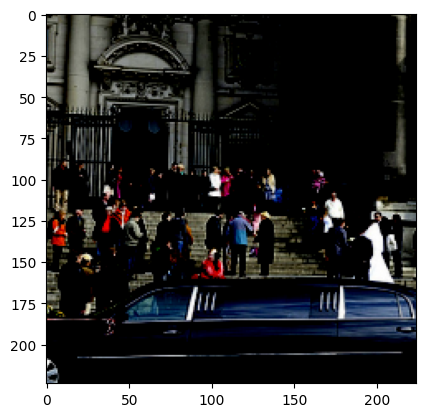

In [27]:
import random
random_index = random.randint(0, len(train_dataset) - 1)

random_image, random_label, att_mask = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
print("Attension mask shape", att_mask.shape)
plt.imshow(random_image.permute(1, 2,0))
print(vocab.decode(random_label.tolist()))

In [28]:
for image, caption, att_mask in train_loader:
    print("Full Batch Caption", caption.shape)
    print("Full Batch Attention Mask shape", att_mask.shape)
    print("Full Batch Image Shape", image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

Full Batch Caption torch.Size([32, 45])
Full Batch Attention Mask shape torch.Size([32, 45])
Full Batch Image Shape torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


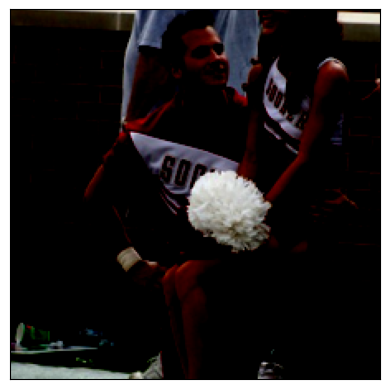

A boy cheerleader has a girl cheerleader on his knee .
A female cheerleader sits on the knee of a male cheerleader .
cheerleaders taking a break
The cheerleader in red and white is sitting on the knee of a man also wearing red and white .
Two cheerleaders are sitting at a football game .


In [9]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocab,
                        transform=val_transform, train=False)
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label, _ = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print(vocab.decode(random_label[0].tolist()))
print(vocab.decode(random_label[1].tolist()))
print(vocab.decode(random_label[2].tolist()))
print(vocab.decode(random_label[3].tolist()))
print(vocab.decode(random_label[4].tolist()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 45])
torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


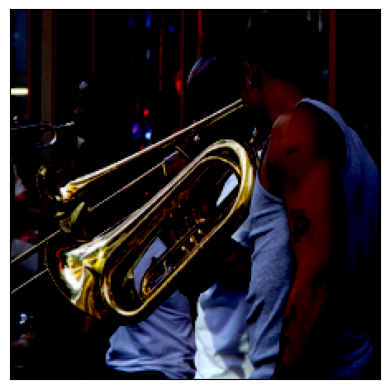

A group of guys play instruments outside .
A group of men playing brass instruments .
A jazz band plays outside .
Group of men play musical instruments outdoors .
men play saxaphones outside a building .


In [10]:
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
for image, caption, att_mask in val_loader:
    print(caption.shape)
    print(att_mask.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print(vocab.decode(random_label[0].tolist()))
    print(vocab.decode(random_label[1].tolist()))
    print(vocab.decode(random_label[2].tolist()))
    print(vocab.decode(random_label[3].tolist()))
    print(vocab.decode(random_label[4].tolist()))
    break

## Using Model

In [8]:
model = Captioner()

Loading weights from pretrained gpt:  gpt2


In [9]:
for img, caption, attn_mask in train_loader:
    output = model(img[1].unsqueeze(0), caption[1].unsqueeze(0)[:,:-1], attn_mask[1].unsqueeze(0)[:,:-1])
    print(output.shape)
    res = output.argmax(dim=-1)
    print(res)
    print(vocab.decode(res.squeeze(0)))
    print("-"*100)
    output = model.greedy(img)
    print(vocab.decode(output[10]))
    break

torch.Size([1, 45, 50257])
tensor([[  11,   11,  198,   13,   11,   13,  661,  198,  198, 2042, 3290,  198,
         1010,  198,  262,   13,   11,  286,  198,  464,  198,  464,  464,  464,
          198,  464,  319,  464,  464,  464,  198,  198,  464,  198,  198,  198,
          198,  464,  464,  464,  198,  464,  198,  198,  464]])
,,
.,. people

 black dog
ters
 the., of
The
TheTheThe
The onTheTheThe

The



TheTheThe
The

The
----------------------------------------------------------------------------------------------------
 the.

The




The


The
The
The
,
The Trump

The


The
The

The
TheThe two and


The


In [10]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print(device)

mps


In [11]:
num_epochs = 5
lr= 3e-4
load_model = False
save_model = True
train_step = 0
val_step = 0
best_blue = 0
writer = SummaryWriter(log_dir="runs/flickr")

In [12]:
model_path = "state_dict.pt"
model = model.to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [13]:
start_epoch = 0
if load_model:
    state_dict = torch.load(model_path)
    model = state_dict['model']
    optimizer = state_dict['optimizer']
    train_step = state_dict['train_step']
    val_step = state_dict['val_step']
    start_epoch = 1 + state_dict['epochs']

In [14]:
for epoch in range(start_epoch, num_epochs):
    #train_loader, model: Captioner, device, criterion, optimizer, epoch, writer, global_ste
    train_step = train_epoch(train_loader=train_loader, model=model, device=device,
                            criterion=criterion, optimizer=optimizer, epoch=epoch, writer=writer, global_step=train_step)
    

    bleu_4, val_step, val_loss = val_epoch(validation_loader=val_loader,
                                model=model, criterion=criterion, device=device, 
                                epoch=epoch, global_step=val_step, vocabulary=vocab, writer=writer)

    scheduler.step(val_loss)
    if save_model and best_blue <= bleu_4:
        print("saving most recent model")
        best_blue = bleu_4
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "train_step": train_step,
            "val_step": val_step,
            "epoch": start_epoch
        }
        torch.save(checkpoint, model_path)

Training Processing Epoch: 00:   0%|          | 0/1012 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 18.03 GB, other allocations: 126.02 MB, max allowed: 18.13 GB). Tried to allocate 256 bytes on shared pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [3]:
from vision.model.pretrained import Captioner, GPT


In [4]:
model = GPT.from_pretrained("gpt2")


Loading weights from pretrained gpt:  gpt2


In [5]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.3, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CasualSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.3, inplace=False)
          (resid_dropout): Dropout(p=0.3, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head)

In [7]:
from transformers import GPT2LMHeadModel
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

In [6]:
model_hf

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)